# Setting

## Library

In [2]:
# 데이터 다루기
import pandas as pd
import numpy as np
from itertools import combinations

# 전처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, FastICA
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

# 모델링
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 기타
import os
import random

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

## Fixed Random Seed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Data Set

## Googel Drive Mount

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip File

In [7]:
!unzip --qq '/content/drive/MyDrive/머신러닝 엔지니어링/데이콘/사기거래/data/사기거래.zip'

## Load Train / Val / Test Set

In [8]:
train = pd.read_csv('/content/train.csv')
val = pd.read_csv('/content/val.csv')
test = pd.read_csv('/content/test.csv')

In [9]:
val['Class'].value_counts()

0    28432
1       30
Name: Class, dtype: int64

# Preprocessing

## Feature Selection

In [79]:
X_train = train.drop(columns=['ID']) 

X_val = val.drop(columns=['ID', 'Class']) 
y_val = val['Class']

X_test = test.drop(columns=['ID'])

In [80]:
X_train = X_train[['V4', 'V7', 'V8', 'V9', 'V10', 'V11',
                   'V12', 'V14', 'V16', 'V17', 'V18']]

X_val = X_val[['V4', 'V7', 'V8', 'V9', 'V10', 'V11',
               'V12', 'V14', 'V16', 'V17', 'V18']]

X_test = X_test[['V4', 'V7', 'V8', 'V9', 'V10', 'V11',
                 'V12', 'V14', 'V16', 'V17', 'V18']]

In [81]:
len(X_train.columns)

11

## Scaling

In [82]:
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler(quantile_range=(45.0, 55.0))

scaled_train = scaler.fit_transform(X_train)
scaled_val = scaler.transform(X_val)
scaled_test = scaler.transform(X_test)

scaled_train = pd.DataFrame(scaled_train)
scaled_val = pd.DataFrame(scaled_val)
scaled_test = pd.DataFrame(scaled_test)

In [83]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler(quantile_range=(45.0, 55.0))

scaled_train = scaler.fit_transform(scaled_train)
scaled_val = scaler.transform(scaled_val)
scaled_test = scaler.transform(scaled_test)

scaled_train = pd.DataFrame(scaled_train)
scaled_val = pd.DataFrame(scaled_val)
scaled_test = pd.DataFrame(scaled_test)

## 파생 변수

In [84]:
main_columns = list(scaled_train.columns)

com_main = list(combinations(main_columns, 3))
print(len(com_main))
print(com_main)

165
[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 3, 10), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 4, 9), (0, 4, 10), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 5, 9), (0, 5, 10), (0, 6, 7), (0, 6, 8), (0, 6, 9), (0, 6, 10), (0, 7, 8), (0, 7, 9), (0, 7, 10), (0, 8, 9), (0, 8, 10), (0, 9, 10), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 2, 9), (1, 2, 10), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 3, 9), (1, 3, 10), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 4, 9), (1, 4, 10), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 5, 9), (1, 5, 10), (1, 6, 7), (1, 6, 8), (1, 6, 9), (1, 6, 10), (1, 7, 8), (1, 7, 9), (1, 7, 10), (1, 8, 9), (1, 8, 10), (1, 9, 10), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 3, 9), (2, 3, 10), (2, 4, 5)

In [85]:
for com in com_main:

  x = com[0]
  y = com[1]
  z = com[-1]

  scaled_train[f'{x}_{y}_{z}_mean'] = (scaled_train[x] + scaled_train[y] + scaled_train[z]) / 3
  scaled_val[f'{x}_{y}_{z}_mean'] = (scaled_val[x] + scaled_val[y] + scaled_val[z]) / 3
  scaled_test[f'{x}_{y}_{z}_mean'] = (scaled_test[x] + scaled_test[y] + scaled_test[z]) / 3


In [86]:
print(len(scaled_train.columns))
n_components = len(scaled_train.columns)

176


## Dimension Reduction

In [87]:
pca = PCA()
pca.fit(scaled_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
N_COMPONETS = np.argmax(cumsum>=0.999) + 1
print(N_COMPONETS)

11


In [96]:
dimesion_reducer = PCA(n_components=128)
#dimesion_reducer = SparsePCA(n_components=232, alpha=0.001)
#dimesion_reducer = SparseRandomProjection(n_components=14, eps=0.1, random_state=42)
#dimesion_reducer = FastICA(n_components=232, algorithm='parallel', whiten=True, max_iter=100, random_state=42)


reduced_train = dimesion_reducer.fit_transform(scaled_train)
reduced_val = dimesion_reducer.transform(scaled_val)
reduced_test = dimesion_reducer.transform(scaled_test)

reduced_train = pd.DataFrame(reduced_train)
reduced_val = pd.DataFrame(reduced_val)
reduced_test = pd.DataFrame(reduced_test)

# Modeling

In [108]:
model = IsolationForest(n_estimators=1000,
                        max_samples=0.9,
                        max_features=0.4,
                        contamination=30/28432,
                        random_state=42,
                        verbose=0)

In [109]:
model.fit(reduced_train)

IsolationForest(contamination=0.0010551491277433877, max_features=0.4,
                max_samples=0.9, n_estimators=1000, random_state=42)

# Evaluation

In [110]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [111]:
pred_val = model.predict(reduced_val) # model prediction
pred_val = get_pred_label(pred_val)

In [112]:
val_score = f1_score(y_val, pred_val, average='macro')

In [113]:
# 0.0.8271056766827749
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(y_val, pred_val))

Validation F1 Score : [0.8271056766827749]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.72      0.60      0.65        30

    accuracy                           1.00     28462
   macro avg       0.86      0.80      0.83     28462
weighted avg       1.00      1.00      1.00     28462



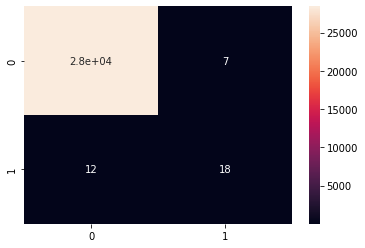

In [114]:
cf_matrix = confusion_matrix(y_val, pred_val)
sns.heatmap(cf_matrix, annot=True)
plt.show()

# Inference

In [115]:
pred_test = model.predict(reduced_test) # model prediction
pred_test = get_pred_label(pred_test)

# Submission

In [116]:
submit = pd.read_csv('./sample_submission.csv')

In [117]:
submit['Class'] = pred_test
submit.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [118]:
submit.to_csv('./submission_9.csv', index=False)